In [7]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import datasets

import torch

from torch.utils.data import (
    DataLoader,
    RandomSampler,
    TensorDataset,
    SequentialSampler,
    random_split,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import random

import matplotlib.pyplot as plt

def classification_report(true, preds, labels=["negative", "neutral", "positive"]) -> None:
    avearge = "weighted"
    print(f"F1-score: {f1_score(true, preds, average=avearge)}")
    print(f"Precision: {precision_score(true, preds, average=avearge)}")
    print(f"Recall: {recall_score(true, preds, average=avearge)}")
    print(f"Accuracy: {accuracy_score(true, preds)}")

    ConfusionMatrixDisplay(
        confusion_matrix(true, preds, normalize="true"),
        display_labels=labels,
    ).plot()


BERT_MODEL = "DeepPavlov/rubert-base-cased"
BERT_MAX_LENGTH = 128
BATCH_SIZE = 32
DATASET_PATH = "../data/labeled_rusentiment_text.csv"
N_SAMPLES = 100000


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Доступные GPU устройства: {torch.cuda.device_count()}")
    print(f"Используемое GPU устройство: {torch.cuda.get_device_name()}")

else:
    print("Доступных GPU нет")
    device = torch.device("cpu")

Доступные GPU устройства: 1
Используемое GPU устройство: NVIDIA GeForce RTX 3070 Ti


In [41]:
data = pd.read_csv(DATASET_PATH, index_col=0)
data = data.replace({"sentiment": {1: "positive", 0: "neutral", -1: "negative"}})
data.head()

,text,sentiment
0,украина это часть руси искусственно отделенная...,negative
1,говорить относительно небольшой коррупции обра...,negative
2,своими поляками сделали русских понятно литовс...,neutral
3,фильмы зрители любят диковинное соседка пятом ...,neutral
4,государство платить посмотрите денежный поток ...,negative


In [10]:
data = data.drop_duplicates(subset=["text"])

In [11]:
data.isnull().sum()

Unnamed: 0    0
text          1
sentiment     0
dtype: int64

In [12]:
data = data.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)

In [13]:
label_encoder = LabelEncoder()
label_encoder.fit(data["sentiment"])

LabelEncoder()

In [14]:
label_encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [15]:
data["sentiment"] = label_encoder.transform(data["sentiment"])

In [16]:
data["sentiment"].value_counts()

2    169778
0    148925
1     25897
Name: sentiment, dtype: int64

In [17]:
# data = pd.concat([
#     data[data["sentiment"] == 0].sample(N_SAMPLES),
#     data[data["sentiment"] == 1].sample(N_SAMPLES),
#     data[data["sentiment"] == 2].sample(N_SAMPLES),
# ])
data = data.sample(N_SAMPLES)
data["sentiment"].value_counts()

2    49429
0    43253
1     7318
Name: sentiment, dtype: int64

In [18]:
data = data.rename(columns={"sentiment": "label"})
train_data, test_data = train_test_split(data, test_size=0.4)
train_data.to_csv("ru_sentiment_train_data.csv", index=False)
test_data.to_csv("ru_sentiment_test_data.csv", index=False)

In [19]:
rusentiment_dataset = datasets.load_dataset("csv", data_files={
    "train": "ru_sentiment_train_data.csv",
    "test": "ru_sentiment_test_data.csv",
})
train_data = rusentiment_dataset["train"]
test_data = rusentiment_dataset["test"]
train_data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

C:\Users\Dmitry\anaconda3\envs\vkr\lib\site-packages\datasets\download\streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

C:\Users\Dmitry\anaconda3\envs\vkr\lib\site-packages\datasets\download\streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to C:/Users/Dmitry/.cache/huggingface/datasets/csv/default-1c7e16cfeaa78b23/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['Unnamed: 0', 'text', 'label'],
    num_rows: 60000
})

In [20]:
train_data[1]

{'Unnamed: 0': 94454, 'text': 'смотришь какие сериалы', 'label': 0}

In [21]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

In [22]:
train_data[0]["text"]

'штаны целом нормальные понятный крой приседаешь очень сильно сползают попу видно это неудобно мои параметры талия бедра нормально влезут большие размеры посылочку принес курьер домой это приятно'

In [23]:
tokenizer(train_data[0]["text"])

{'input_ids': [101, 76924, 13473, 85289, 14726, 1916, 51688, 860, 5539, 13425, 26318, 7805, 13526, 2787, 53116, 3075, 4441, 876, 26506, 3998, 119108, 40648, 28562, 79419, 878, 61477, 43880, 19109, 22771, 868, 17096, 26566, 32329, 19459, 15776, 74478, 18829, 3998, 73337, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [24]:
max_len = 0
sentences = train_data["text"]

for sentence in tqdm(sentences):
    input_ids = tokenizer.encode(sentence)
    max_len = max(max_len, len(input_ids))

print(f"Максимальная длина вектора: {max_len}")
print(f"Превышает допустимый размер: {max_len > BERT_MAX_LENGTH}")

100%|██████████| 60000/60000 [00:10<00:00, 5732.55it/s]

Максимальная длина вектора: 29180
Превышает допустимый размер: True


In [25]:
vector_max_len = min(max_len, BERT_MAX_LENGTH)


def transform_sentences(sentences: list) -> tuple:
    input_ids = []
    attention_masks = []
    for sentence in tqdm(sentences):
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=vector_max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


input_ids, attention_masks = transform_sentences(train_data["text"])
labels = torch.tensor(train_data["label"])
test_input_ids, test_attention_masks = transform_sentences(test_data["text"])
test_labels = torch.tensor(test_data["label"])

print(f"Исходное предложение: {sentences[1]}")
print(f"Трансформрованное: {input_ids[1]}")

  0%|          | 0/60000 [00:00<?, ?it/s]C:\Users\Dmitry\anaconda3\envs\vkr\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 40000/40000 [00:11<00:00, 3362.48it/s]


Исходное предложение: смотришь какие сериалы
Трансформрованное: tensor([   101, 112986,  63819,  19201,  71043,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0, 

In [26]:
print(f"Исходное предложение: {sentences[10]}")
print(f"Трансформрованное: {input_ids[10]}")

Исходное предложение: футболка хорошая посылка дошла очень быстро советую продавца
Трансформрованное: tensor([  101,  7845,  1714, 55167, 32329,  1714, 39561,  7805, 13586, 32336,
          898, 74625,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

In [27]:
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_size = int(0.6 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

print(f"Размер тренировочного набора: {train_size}")
print(f"Размер проверочного набора: {val_size}")

Размер тренировочного набора: 36000
Размер проверочного набора: 24000


In [28]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE,
)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE,
)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE,
)
common_train_dataloader = DataLoader(
    dataset,
    sampler=SequentialSampler(train_dataset),
    batch_size=BATCH_SIZE,
)

In [29]:
num_labels=3

bert_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL,
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [42]:
LEARNING_RATE = 2e-6
EPS = 1e-8

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=LEARNING_RATE, eps=EPS)

In [31]:
EPOCHS = 10

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

In [32]:
torch.cuda.empty_cache()
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [33]:
def f1_weighted_score(preds, labels):
    pred_flatten = np.argmax(preds, axis=1).flatten()
    labels_flatten = labels.flatten()
    return f1_score(labels_flatten, pred_flatten, average="weighted")

In [34]:
training_stats = []

train_pred_labels = []
train_true_labels = []

valid_pred_labels = []
valid_true_labels = []

for epoch in range(1, EPOCHS + 1):
    print("")
    print(f"================{epoch}/{EPOCHS}==================")
    print("Обучение...")

    total_train_loss = 0

    bert_model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        results = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )

        loss = results["loss"]
        logits = results["logits"]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()
        train_true_labels.append(label_ids)
        train_pred_labels.append(logits)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    print(f"Средняя ошибка: {avg_train_loss}")

    bert_model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    print("Проверка...")

    for batch in tqdm(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            results = bert_model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )

        loss = results["loss"]
        logits = results["logits"]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        valid_pred_labels.append(logits)
        valid_true_labels.append(label_ids)

        total_eval_accuracy += f1_weighted_score(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    print(f"Средняя ошибка: {avg_val_loss}")
    print(f"F1-мерика: {avg_val_accuracy}")

    training_stats.append({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": avg_val_accuracy,
    })


================1/10==================
Обучение...


100%|██████████| 1125/1125 [04:40<00:00,  4.01it/s]


Средняя ошибка: 0.6348537105719249
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.95it/s]


Средняя ошибка: 0.5930380531549454
F1-мерика: 0.701791315192092

================2/10==================
Обучение...


100%|██████████| 1125/1125 [04:38<00:00,  4.04it/s]


Средняя ошибка: 0.5048292065991296
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.96it/s]


Средняя ошибка: 0.5983280993700028
F1-мерика: 0.7118932009410976

================3/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.07it/s]


Средняя ошибка: 0.36100509060753716
Проверка...


100%|██████████| 750/750 [00:57<00:00, 13.00it/s]


Средняя ошибка: 0.6729618072708448
F1-мерика: 0.7096984484554465

================4/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.07it/s]


Средняя ошибка: 0.23002201681666903
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.99it/s]


Средняя ошибка: 0.8927930404543877
F1-мерика: 0.6969684746860844

================5/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.07it/s]


Средняя ошибка: 0.14809251174206536
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.99it/s]


Средняя ошибка: 1.1800317405064902
F1-мерика: 0.6894329954906512

================6/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.06it/s]


Средняя ошибка: 0.10584201806990637
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.98it/s]


Средняя ошибка: 1.370074328104655
F1-мерика: 0.6882167800177105

================7/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.06it/s]


Средняя ошибка: 0.08084636378500404
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.98it/s]


Средняя ошибка: 1.6804269304474195
F1-мерика: 0.6880404893468288

================8/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.06it/s]


Средняя ошибка: 0.06305221315033527
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.97it/s]


Средняя ошибка: 1.9405029367208482
F1-мерика: 0.695703281886646

================9/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.06it/s]


Средняя ошибка: 0.05141539130019697
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.97it/s]


Средняя ошибка: 2.1631490312814714
F1-мерика: 0.692073127669021

================10/10==================
Обучение...


100%|██████████| 1125/1125 [04:36<00:00,  4.06it/s]


Средняя ошибка: 0.0355944096590651
Проверка...


100%|██████████| 750/750 [00:57<00:00, 12.97it/s]

Средняя ошибка: 2.1484648440678913
F1-мерика: 0.6937471573301626


In [35]:
training_stats_df = pd.DataFrame(data=training_stats)
training_stats_df = training_stats_df.set_index("epoch")
training_stats_df

,train_loss,val_loss,val_accuracy
epoch,,,
1,0.634854,0.593038,0.701791
2,0.504829,0.598328,0.711893
3,0.361005,0.672962,0.709698
4,0.230022,0.892793,0.696968
5,0.148093,1.180032,0.689433
6,0.105842,1.370074,0.688217
7,0.080846,1.680427,0.688040
8,0.063052,1.940503,0.695703
9,0.051415,2.163149,0.692073


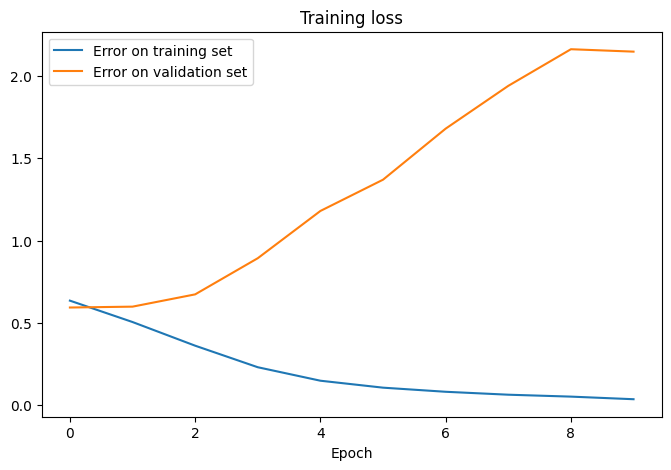

In [36]:
plt.figure(figsize=(8,5))
plt.title("Training loss")
plt.xlabel("Epoch")
plt.plot(training_stats_df["train_loss"].to_list(), label="Error on training set")
plt.plot(training_stats_df["val_loss"].to_list(), label="Error on validation set")
plt.legend()
plt.show()

In [37]:
#Тестируем на отложенном наборе
test_pred_labels = []
test_true_labels = []

bert_model.eval()


for batch in tqdm(test_dataloader):

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():

        results = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )

    loss = results["loss"]
    logits = results["logits"]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    test_pred_labels.append(logits)
    test_true_labels.append(label_ids)

100%|██████████| 1250/1250 [01:34<00:00, 13.17it/s]


In [38]:
def transform_predictions(pred_labels, true_labels) -> tuple:

    flatten_true_labels = []

    for true_label in tqdm(true_labels):
        flatten_true_labels.extend(true_label.flatten().tolist())

    flatten_pred_labels = []
    two_dims_preds = []

    for pred_label in pred_labels:
        two_dims_preds.extend(pred_label.tolist())
        flatten_pred_labels.extend(np.argmax(pred_label, axis=1).tolist())

    return flatten_true_labels, flatten_pred_labels, two_dims_preds

In [39]:
train_true_labels, train_pred_labels, train_two_dims_preds = transform_predictions(train_pred_labels, train_true_labels)
test_true_labels, test_pred_labels, test_two_dims_preds = transform_predictions(test_pred_labels, test_true_labels)

100%|██████████| 1250/1250 [00:00<00:00, 624821.83it/s]


F1-score: 0.6897362610510891
Precision: 0.6909204160618397
Recall: 0.689075
Accuracy: 0.689075


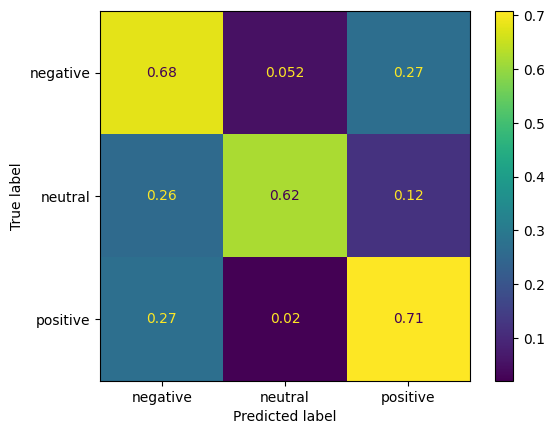

In [40]:
classification_report(test_true_labels, test_pred_labels)